--------------------------------------------------------------------------------
# **Trabalho final *I$^{2}$A$^{2}$***

* **Autora: Carolina Maria Nunes Bezerra**
* **Data de entrega: 12/Junho/22**
----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Business understanding

## Problem statement

Este trabalho baseia-se no mercado financeiro de ações. Deve-se encontrar um padrão de comportamento ao longo do tempo entre os ativos (entende-se: ação, fundos, ETFs) com a ação Toronto Dominion Bank (TD). Essa análise será feita a partir da comparação do intervalo de tempo compreendido entre 01/12/21 a 02/02/22 da ação TD (Figura 1) ao longo de toda série temporal dos demais ativos.

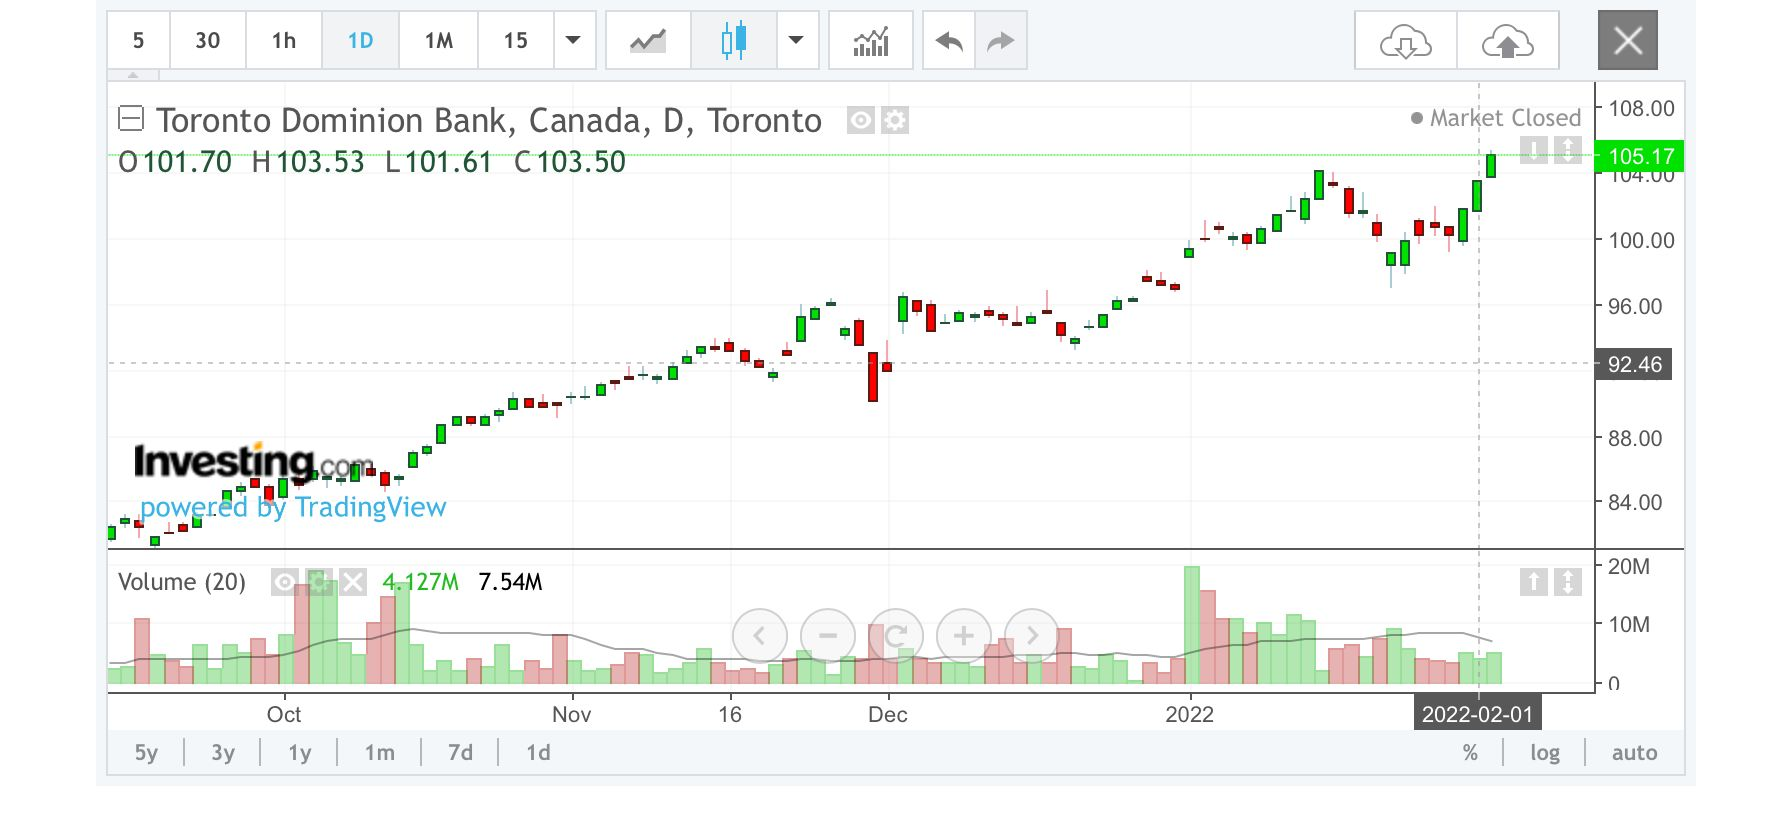
Figura 1: Toronto Dominion Bank (TD)

## Some business questions before moving on
1.   Qual ou quais atributos mais relevantes devemos considerar para análise? 
2.   Qual melhor técnica utilizar para saber quais são os melhores ativos para depois aplicar o padrão TD?
3.   Como realizar a busca desse padrão? 



# Data understanding

## Importando dataset e bibliotecas necessárias 

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
pathRaiz='/content/drive/MyDrive/Colab Notebooks'
os.chdir(pathRaiz)
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks'

In [4]:
os.listdir()

['database.parquet',
 'LerDados.ipynb',
 'I2A2_Desafio_Titanic.ipynb',
 'Gráfico-TD.jpeg',
 '=0.54',
 '=1.5',
 'Cópia de Desafio_final_i2a2.ipynb',
 'Desafio_final_i2a2.ipynb']

In [5]:
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install numba>=0.54
!pip install stumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install scipy>=1.5

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns

from fastparquet import ParquetFile, write
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pylab as plt
import plotly.graph_objs as go
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from datetime import datetime

In [10]:
from scipy import constants
# import scipy
# import numpy.testing as npt
# from matplotlib.patches import Rectangle
import stumpy

In [11]:
import numba

print(numba.__version__)

0.55.2


In [12]:
import scipy

print(scipy.__version__)

1.7.3


## Informações do dataset

Em primeiro lugar, vamos entender o que um candle (Figura 2) representa em um gráfico de movimentação financeira, de acordo com os atributos de nosso dataset.

<img src="https://bullsonwallstreet.com/wp-content/uploads/2019/01/candlestick-1.png" alt="figue2" width=500>

Figura 2: Candles.

* **Open**: Valor de abertura do mercado;
* **High**: Máximo valor atingido;
* **Low**: Menor valor atingido;
* **Close**: Valor de fechamento;
* **Adj Close**: Valor de fechamento após as deduções sobre o ativo. O preço de fechamento ajustado altera o preço de fechamento de uma ação para refletir o valor dessa ação após a contabilização de quaisquer ações corporativas. É frequentemente usado ao examinar retornos históricos ou fazer uma análise detalhada do desempenho passado.
* **Volume**: Volume de negociação (compra e venda) do ativo no mercado.
* **Ticker**: Abreviação do ativo.
* **Exchange**: Bolsa de valores onde o ativo é negociado.

Unindo o ticker do ativo a sua respectiva exchange. Assim, fica mais fácil de ter a informação de qual bolsa cada ativo corresponde.

In [13]:
dtf_full = ParquetFile('database.parquet').to_pandas()
dtf_full['Ticker_Exchange'] = dtf_full['Ticker'] + '_' + dtf_full['Exchange']
dtf_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Exchange,Ticker_Exchange
0,2008-09-02,25.100143,25.536482,24.527897,24.670959,22.517595,2876665.0,A,NYSE,A_NYSE
1,2008-09-03,24.570814,24.678112,23.862661,24.184549,22.073639,3855265.0,A,NYSE,A_NYSE
2,2008-09-04,23.977110,23.984262,22.989986,23.018599,21.009457,3656609.0,A,NYSE,A_NYSE
3,2008-09-05,22.889843,23.547926,22.711016,23.454935,21.407715,3217357.0,A,NYSE,A_NYSE
4,2008-09-08,23.876966,23.977110,23.297567,23.583691,21.525227,3046102.0,A,NYSE,A_NYSE


In [14]:
dtf_full.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Exchange,Ticker_Exchange
17312557,2022-03-22,28.040001,28.049999,28.040001,28.049999,28.049999,500.0,ZZZD,TO,ZZZD_TO
17312558,2022-03-23,27.990000,27.990000,27.850000,27.889999,27.889999,1700.0,ZZZD,TO,ZZZD_TO
17312559,2022-03-24,27.809999,27.809999,27.809999,27.809999,27.809999,0.0,ZZZD,TO,ZZZD_TO
17312560,2022-03-25,28.090000,28.090000,27.889999,27.889999,27.889999,2400.0,ZZZD,TO,ZZZD_TO
17312561,2022-03-28,27.950001,27.980000,27.850000,27.980000,27.980000,2000.0,ZZZD,TO,ZZZD_TO


In [15]:
dtf_full.shape

(17312562, 10)

Vimos que nosso dataset possui mais de 17 milhões de linhas. É possível notar que todas as linhas estão organizadas por data para cada ativo. 

# Data preparation


Para iniciarmos a preparação dos dados antes de aplicar a modelagem, precisamos escolher qual atributo iremos considerar. Então a analise do problema será pelos dados de fechamento, que estão armazenados na coluna `Close`. Vamos separar em um novo dataframe as informações necessárias. 

In [16]:
df_full_close = dtf_full[['Date', 'Close', 'Ticker_Exchange']].copy().reset_index()
df_full_close.head()

,index,Date,Close,Ticker_Exchange
0,0,2008-09-02,24.670959,A_NYSE
1,1,2008-09-03,24.184549,A_NYSE
2,2,2008-09-04,23.018599,A_NYSE
3,3,2008-09-05,23.454935,A_NYSE
4,4,2008-09-08,23.583691,A_NYSE


Aplicando o método `pivot_table()` passamos todos os dados de fechamentos para as linhas e separamos os ativos por colunas.

In [17]:
df_full_pivot = df_full_close.pivot_table('Close', ['Date'], 'Ticker_Exchange')

In [18]:
df_full_pivot.head(3)

Ticker_Exchange,AAB_TO,AACG_NASDAQ,AACI_NASDAQ,AAC_NYSE,AADI_NASDAQ,AAIC_NYSE,AAIN_NYSE,AAL_NASDAQ,AAME_NASDAQ,AAN_NYSE,...,ZWT_TO,ZWU_TO,ZXM_TO,ZYME_NYSE,ZYNE_NASDAQ,ZYXI_NASDAQ,ZY_NASDAQ,ZZZD_TO,ZZZ_TO,Z_NASDAQ
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-02,0.40,12.50,NaN,NaN,NaN,36.000000,NaN,8.82,1.55,NaN,...,NaN,NaN,NaN,NaN,NaN,4.863636,NaN,NaN,NaN,NaN
2008-09-03,0.39,11.77,NaN,NaN,NaN,37.400002,NaN,8.54,1.55,NaN,...,NaN,NaN,NaN,NaN,NaN,4.772727,NaN,NaN,NaN,NaN
2008-09-04,0.35,11.58,NaN,NaN,NaN,37.200001,NaN,7.65,1.55,NaN,...,NaN,NaN,NaN,NaN,NaN,4.554545,NaN,NaN,NaN,NaN


In [19]:
df_full_pivot.tail(3)

Ticker_Exchange,AAB_TO,AACG_NASDAQ,AACI_NASDAQ,AAC_NYSE,AADI_NASDAQ,AAIC_NYSE,AAIN_NYSE,AAL_NASDAQ,AAME_NASDAQ,AAN_NYSE,...,ZWT_TO,ZWU_TO,ZXM_TO,ZYME_NYSE,ZYNE_NASDAQ,ZYXI_NASDAQ,ZY_NASDAQ,ZZZD_TO,ZZZ_TO,Z_NASDAQ
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-24,0.12,1.44,9.83,9.79,18.389999,3.51,24.837,16.719999,2.83,21.400000,...,30.670000,13.19,38.599998,7.38,2.10,6.36,3.20,27.809999,29.900000,55.160000
2022-03-25,0.12,1.45,9.87,9.78,17.820000,3.50,24.837,17.010000,2.85,21.889999,...,30.549999,13.32,38.889999,7.00,2.09,6.32,3.06,27.889999,29.450001,52.040001
2022-03-28,0.13,1.35,9.87,9.78,17.139999,3.55,24.987,17.299999,2.85,21.920000,...,31.070000,13.34,38.889999,6.94,2.06,6.18,2.88,27.980000,29.549999,52.799999


In [20]:
df_full_pivot.shape

(3476, 8932)

Extraindo a quantidade de linhas de `df_full_pivot` temos o total de 3476 linhas, ou seja, todas as datas em que o mercado de ações esteve aberto a partir de 2008-09-02 até 2022-03-28.

In [21]:
df_full_pivot.describe()

Ticker_Exchange,AAB_TO,AACG_NASDAQ,AACI_NASDAQ,AAC_NYSE,AADI_NASDAQ,AAIC_NYSE,AAIN_NYSE,AAL_NASDAQ,AAME_NASDAQ,AAN_NYSE,...,ZWT_TO,ZWU_TO,ZXM_TO,ZYME_NYSE,ZYNE_NASDAQ,ZYXI_NASDAQ,ZY_NASDAQ,ZZZD_TO,ZZZ_TO,Z_NASDAQ
count,3405.000000,3417.000000,95.000000,255.000000,1035.000000,3417.00000,176.000000,3417.000000,3417.000000,336.000000,...,294.000000,2554.000000,1843.000000,1238.000000,1674.000000,3417.000000,236.000000,796.000000,1681.000000,1676.000000
mean,0.242949,4.239388,9.813368,9.776384,26.905894,15.25348,24.923187,24.600723,2.846634,25.332887,...,32.642670,13.777565,28.664102,23.765163,8.851664,3.332931,17.658602,29.561922,26.247713,54.370504
std,0.202537,2.165091,0.062910,0.048988,17.233779,8.69426,0.162527,15.734300,1.086713,4.760504,...,2.296913,1.151385,6.026380,12.984221,5.515363,4.916458,14.499051,1.763811,7.600478,32.069172
min,0.020000,0.670000,9.340000,9.670000,6.750000,1.70000,24.410000,1.970000,0.450000,16.370001,...,27.870001,9.190000,19.790001,6.000000,1.830000,0.081818,2.880000,25.430000,8.410000,16.010000
25%,0.130000,2.910000,9.795000,9.750000,15.000000,7.58000,24.820000,10.060000,2.000000,21.657500,...,30.500000,12.840000,23.570000,13.000000,4.482500,0.327273,6.650000,28.120001,19.570000,34.657500
50%,0.160000,4.200000,9.815000,9.770000,21.900000,14.21000,24.950001,20.940001,2.850000,24.935000,...,32.490000,13.800000,27.700001,20.160000,7.285000,0.727273,11.085000,28.714999,27.160000,42.610001
75%,0.330000,5.110000,9.845000,9.800000,31.049999,23.59000,25.000000,39.189999,3.830000,27.952500,...,34.557501,14.827500,31.100000,34.595000,11.560000,3.963636,34.692500,31.520000,32.610001,59.415001
max,1.020000,14.300000,9.910000,10.000000,75.000000,40.00000,25.700001,58.470001,6.530000,37.150002,...,36.689999,16.110001,44.169998,56.810001,36.490002,25.981817,48.500000,32.720001,42.310001,199.899994


Agora, vamos extrair a quantidade de dados ausentes de nosso dataframe.

In [22]:
missing_values = df_full_pivot.isna().mean()*100
missing_values.sort_values(ascending=False)

Ticker_Exchange
CASH_TO        99.971231
NCG_TO         99.971231
ECCX_NYSE      99.165708
MODD_NASDAQ    99.079402
ZEQT_TO        99.050633
                 ...    
HOMB_NYSE       1.697353
HOLX_NASDAQ     1.697353
HOLI_NASDAQ     1.697353
RRC_NYSE        1.697353
KEY_NYSE        1.697353
Length: 8932, dtype: float64

Nas primeiras linhas nota-se que temos ativos com quase a totalidade dos dados de fechamento ausentes. Uma das razões para isso é que esses ativos podem possuir pouco tempo que foram inseridos nas exchanges ou foram retirados das mesmas.

Agora iremos separar o nosso padrão TD_TO. O período compreendido entre 2021-12-01 e 2022-02-02, como mencionado anteriormente, será o nosso intervalo para encontrar padrões nas movimentações financeiras dos outros ativos.

In [23]:
# df_TD_TO = pd.DataFrame()
df_TD_TO = df_full_close[df_full_close['Ticker_Exchange'] == 'TD_TO'].set_index('Date')
df_TD_TO.head()

,index,Close,Ticker_Exchange
Date,,,
2008-09-02,14704942,30.799999,TD_TO
2008-09-03,14704943,31.059999,TD_TO
2008-09-04,14704944,30.559999,TD_TO
2008-09-05,14704945,30.469999,TD_TO
2008-09-08,14704946,31.184999,TD_TO


In [24]:
df_TD_TO_pattern = df_TD_TO.loc['2021-12-01':'2022-02-02']
df_TD_TO_pattern.head()

,index,Close,Ticker_Exchange
Date,,,
2021-12-01,14708267,91.980003,TD_TO
2021-12-02,14708268,96.500000,TD_TO
2021-12-03,14708269,95.589996,TD_TO
2021-12-06,14708270,94.449997,TD_TO
2021-12-07,14708271,94.900002,TD_TO


In [25]:
df_TD_TO_pattern.shape

(43, 3)

Temos aqui um total de 43 dias de movimentação no intervalo TD_TO. Logo, devemos considerar todos os ativos que tiveram movimentação de, no mínimo, 43 dias também. Isso corresponde a um total de 98.76% de dados ausentes. Sendo assim, vamos identificar todos os ativos que tiveram mais do que 98.76% dos dados ausentes.

In [26]:
tickers_to_remove = missing_values[missing_values > 98.76]
tickers_to_remove.sort_values(ascending=False)

Ticker_Exchange
CASH_TO         99.971231
NCG_TO          99.971231
ECCX_NYSE       99.165708
MODD_NASDAQ     99.079402
ZEQT_TO         99.050633
APCA_NYSE       98.993096
AREB_NASDAQ     98.993096
ATAKU_NASDAQ    98.993096
HORI_NASDAQ     98.993096
SZZL_NASDAQ     98.993096
SHAP_NYSE       98.993096
NVCT_NASDAQ     98.964327
GFGD_NASDAQ     98.964327
EVE_NYSE        98.964327
ACLX_NASDAQ     98.964327
SSIC_NASDAQ     98.964327
BFAC_NYSE       98.964327
MURFU_NASDAQ    98.935558
GGAA_NASDAQ     98.935558
MTBCO_NASDAQ    98.935558
NVX_NASDAQ      98.906789
BANK_TO         98.906789
MTEK_NASDAQ     98.906789
TGAA_NASDAQ     98.878021
XPDB_NASDAQ     98.878021
ACAXU_NASDAQ    98.878021
IUTE_TO         98.878021
HAIA_NASDAQ     98.878021
FRBN_NASDAQ     98.878021
RJAC_NYSE       98.849252
BWAQU_NASDAQ    98.849252
XSTP_TO         98.849252
TCOA_NYSE       98.849252
PORT_NYSE       98.849252
BRKH_NASDAQ     98.849252
SCUA_NYSE       98.849252
APXI_NASDAQ     98.820483
ATEK_NYSE       98.820

Agora, vamos remover todos esses ativos com mais de 98.76% de dados ausentes.

In [27]:
df_full_pivot = df_full_pivot.drop(df_full_pivot.columns[df_full_pivot.apply(lambda col:col.isna().mean()*100 > 98.76)], axis = 1)

In [28]:
df_full_pivot.head()

Ticker_Exchange,AAB_TO,AACG_NASDAQ,AACI_NASDAQ,AAC_NYSE,AADI_NASDAQ,AAIC_NYSE,AAIN_NYSE,AAL_NASDAQ,AAME_NASDAQ,AAN_NYSE,...,ZWT_TO,ZWU_TO,ZXM_TO,ZYME_NYSE,ZYNE_NASDAQ,ZYXI_NASDAQ,ZY_NASDAQ,ZZZD_TO,ZZZ_TO,Z_NASDAQ
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-02,0.40,12.50,NaN,NaN,NaN,36.000000,NaN,8.82,1.55,NaN,...,NaN,NaN,NaN,NaN,NaN,4.863636,NaN,NaN,NaN,NaN
2008-09-03,0.39,11.77,NaN,NaN,NaN,37.400002,NaN,8.54,1.55,NaN,...,NaN,NaN,NaN,NaN,NaN,4.772727,NaN,NaN,NaN,NaN
2008-09-04,0.35,11.58,NaN,NaN,NaN,37.200001,NaN,7.65,1.55,NaN,...,NaN,NaN,NaN,NaN,NaN,4.554545,NaN,NaN,NaN,NaN
2008-09-05,0.32,11.98,NaN,NaN,NaN,34.400002,NaN,7.91,1.55,NaN,...,NaN,NaN,NaN,NaN,NaN,4.454545,NaN,NaN,NaN,NaN
2008-09-08,0.33,11.73,NaN,NaN,NaN,36.400002,NaN,7.68,1.55,NaN,...,NaN,NaN,NaN,NaN,NaN,4.672727,NaN,NaN,NaN,NaN


In [29]:
tickers_removed = len(df_full_close['Ticker_Exchange'].unique())-df_full_pivot.shape[1]
print("Foram removidos", tickers_removed, 'ativos que tinham menos de 43 dias de movimentação')

Foram removidos 50 ativos que tinham menos de 43 dias de movimentação


# Data modeling

## Correlação de Pearson

Ser capaz de entender a correlação entre diferentes variáveis é um passo fundamental para o entendimento dos dados. A correlação fornece informações substanciais sobre como o modelo pode ser ajustado, entendendo quais variáveis têm os graus mais altos e mais baixos de correlação. Isso permite reduzir as dimensões encontradas em um conjunto de dados, fazendo com que que o modelo opere mais rapidamente.

O primeiro método utilizado para iniciarmos a modelagem dos dados foi a correlação de Pearson. Este é um método de correlação paramétrica, ou seja, mede a dependencia linear entre duas variaveis e depende da distribuição dos dados.

> $r = \frac{∑^n_{i=1} (x_{i}-\bar{x})(y_{i}-\bar{y})}{\sqrt{\sum^n_{i=1}(x_{i}-\bar{x})^2 ∑^n_{i=1}(y_{i}-\bar{y})^2}}$

Em que $x$ e $y$ são vetores de comprimento $n$, e $\bar{x}$ e $\bar{y}$ são as médias. A correlação de Pearson resulta em uma medida normalizada de covariância (ou seja, um valor entre -1 e 1 que mostra o quanto as variáveis variam juntas). As informações retiradas dessa correlação são as seguintes:
* $r = -1$: correlação negativa
* $r = 1$: correlação positiva
* $r = 0$: sem correlação

In [30]:
df_corr_tickers = df_full_pivot.corr(method='pearson')

In [31]:
df_corr_tickers.head()

Ticker_Exchange,AAB_TO,AACG_NASDAQ,AACI_NASDAQ,AAC_NYSE,AADI_NASDAQ,AAIC_NYSE,AAIN_NYSE,AAL_NASDAQ,AAME_NASDAQ,AAN_NYSE,...,ZWT_TO,ZWU_TO,ZXM_TO,ZYME_NYSE,ZYNE_NASDAQ,ZYXI_NASDAQ,ZY_NASDAQ,ZZZD_TO,ZZZ_TO,Z_NASDAQ
Ticker_Exchange,,,,,,,,,,,,,,,,,,,,,
AAB_TO,1.000000,0.640301,-0.100878,0.207693,0.332519,0.535657,-0.130373,-0.549279,-0.332422,0.385941,...,-0.342604,0.465228,0.237763,-0.135803,0.089782,-0.320591,0.827386,-0.609514,0.557850,0.432483
AACG_NASDAQ,0.640301,1.000000,0.029274,0.357053,0.585431,0.538643,0.170862,-0.213777,-0.115518,0.257639,...,-0.240890,0.500455,-0.347079,-0.444516,0.403257,-0.501132,0.803184,-0.256809,0.362320,-0.150835
AACI_NASDAQ,-0.100878,0.029274,1.000000,-0.325640,-0.230175,-0.328159,0.166041,-0.066559,-0.505402,-0.280544,...,-0.370603,0.426311,-0.313708,-0.427849,-0.438654,-0.426624,-0.496005,0.166098,-0.264782,-0.142430
AAC_NYSE,0.207693,0.357053,-0.325640,1.000000,-0.291323,0.446069,0.045748,0.425571,0.281409,0.140151,...,-0.172445,-0.405059,-0.167920,0.122675,0.233296,0.325642,0.305661,-0.357867,0.027971,0.350249
AADI_NASDAQ,0.332519,0.585431,-0.230175,-0.291323,1.000000,0.726328,0.135289,0.677653,0.267231,0.449627,...,0.456235,-0.199518,-0.087856,-0.514398,0.233124,-0.514567,0.284552,-0.310639,0.528944,-0.032387


In [32]:
# separando a correlação com TD_TO:
corr_TDTO = df_corr_tickers['TD_TO'] 

In [33]:
# organizando os ativos mais correlacionados para os menos correlacionados:
corr_TDTO.sort_values(ascending=False)

Ticker_Exchange
TD_TO           1.000000
ZEB_TO          0.988627
XFN_TO          0.988348
HCA_TO          0.988077
RY_TO           0.986689
                  ...   
CDZIP_NASDAQ   -0.939594
CGNT_NASDAQ    -0.941380
HIX_TO         -0.947756
ZPS_TO         -0.957066
CLF_TO         -0.959020
Name: TD_TO, Length: 8882, dtype: float64

In [141]:
df_corr_TDTO = pd.DataFrame(corr_TDTO.sort_values(ascending=False))

In [178]:
# Vejamos os 6 ativos mais correlacionados:
df_corr_TDTO.head(7)

,TD_TO
Ticker_Exchange,
TD_TO,1.000000
ZEB_TO,0.988627
XFN_TO,0.988348
HCA_TO,0.988077
RY_TO,0.986689
CEW_TO,0.984529
XEN_TO,0.981365


In [191]:
# Armazenando em um dataframe os 6 ativos mais correlacionados
df_correlated = df_corr_tickers.loc[['TD_TO', 'ZEB_TO', 'XFN_TO', 'HCA_TO', 'RY_TO', 'CEW_TO', 'XEN_TO'], ['TD_TO', 'ZEB_TO', 'XFN_TO', 'HCA_TO', 'RY_TO', 'CEW_TO', 'XEN_TO']]

In [192]:
df_correlated

Ticker_Exchange,TD_TO,ZEB_TO,XFN_TO,HCA_TO,RY_TO,CEW_TO,XEN_TO
Ticker_Exchange,,,,,,,
TD_TO,1.000000,0.988627,0.988348,0.988077,0.986689,0.984529,0.981365
ZEB_TO,0.988627,1.000000,0.995670,0.997588,0.989243,0.991223,0.985182
XFN_TO,0.988348,0.995670,1.000000,0.995470,0.993677,0.997747,0.989689
HCA_TO,0.988077,0.997588,0.995470,1.000000,0.993641,0.980974,0.983839
RY_TO,0.986689,0.989243,0.993677,0.993641,1.000000,0.991048,0.982013
CEW_TO,0.984529,0.991223,0.997747,0.980974,0.991048,1.000000,0.986282
XEN_TO,0.981365,0.985182,0.989689,0.983839,0.982013,0.986282,1.000000


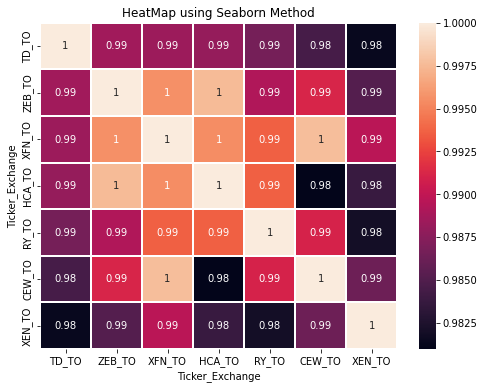

In [195]:
# Vizualização das correlações através de um heatmap
plt.figure(figsize=(8,6))
heat_map = sns.heatmap( df_correlated, linewidth = 1 , annot = True)
plt.title( "HeatMap using Seaborn Method" )
plt.show()

Como podemos perceber, os ativos mais correlacionados com o TD são da mesma exchange, ou seja, pertencem também a bolsa de valores de Toronto. A seguir, é feito uma padronização de toda série de fechamento para cada ativo, afim de facilitar a comparação com o padrão de TD.

In [164]:
df_full_pivot['TD_TO']=(df_full_pivot['TD_TO']-df_full_pivot['TD_TO'].min())/(df_full_pivot['TD_TO'].max()-df_full_pivot['TD_TO'].min())

In [165]:
df_full_pivot['ZEB_TO']=(df_full_pivot['ZEB_TO']-df_full_pivot['ZEB_TO'].min())/(df_full_pivot['ZEB_TO'].max()-df_full_pivot['ZEB_TO'].min())

In [166]:
df_full_pivot['XFN_TO']=(df_full_pivot['XFN_TO']-df_full_pivot['XFN_TO'].min())/(df_full_pivot['XFN_TO'].max()-df_full_pivot['XFN_TO'].min())

In [167]:
df_full_pivot['HCA_TO']=(df_full_pivot['HCA_TO']-df_full_pivot['HCA_TO'].min())/(df_full_pivot['HCA_TO'].max()-df_full_pivot['HCA_TO'].min())

In [168]:
df_full_pivot['RY_TO']=(df_full_pivot['RY_TO']-df_full_pivot['RY_TO'].min())/(df_full_pivot['RY_TO'].max()-df_full_pivot['RY_TO'].min())

In [169]:
df_full_pivot['CEW_TO']=(df_full_pivot['CEW_TO']-df_full_pivot['CEW_TO'].min())/(df_full_pivot['CEW_TO'].max()-df_full_pivot['CEW_TO'].min())

In [179]:
df_full_pivot['XEN_TO']=(df_full_pivot['XEN_TO']-df_full_pivot['XEN_TO'].min())/(df_full_pivot['XEN_TO'].max()-df_full_pivot['XEN_TO'].min())

In [ ]:
df_full_pivot['TD_TO']

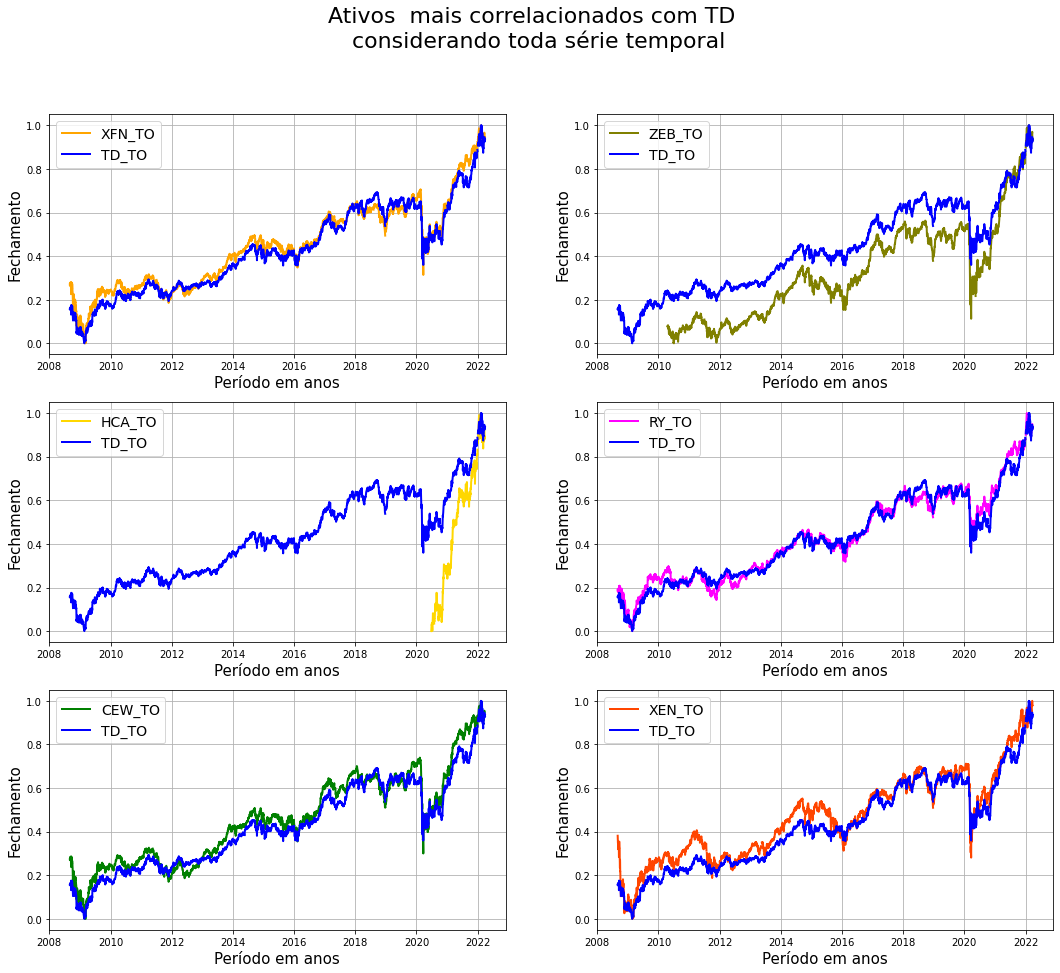

In [282]:
# plt.figure(figsize=(10,10))
Figura, Eixo = plt.subplots( figsize=(18, 15) )

Figura.suptitle('Ativos  mais correlacionados com TD \n considerando toda série temporal', fontsize=22, color='black')

Coluna = 2
Linha = 3

plt.subplot( Linha, Coluna, 1 )
plt.xlabel('Período em anos', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.plot(df_full_pivot['XFN_TO'], lw=2, color='orange', label = 'XFN_TO')
plt.plot(df_full_pivot['TD_TO'], lw=2, color = 'blue', label = 'TD_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.subplot( Linha, Coluna, 2 )
plt.xlabel('Período em anos', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.plot(df_full_pivot['ZEB_TO'], lw=2, color='olive', label = 'ZEB_TO')
plt.plot(df_full_pivot['TD_TO'], lw=2, color = 'blue', label = 'TD_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.subplot( Linha, Coluna, 3 )
plt.xlabel('Período em anos', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.plot(df_full_pivot['HCA_TO'], lw=2, color='gold', label = 'HCA_TO')
plt.plot(df_full_pivot['TD_TO'], lw=2, color = 'blue', label = 'TD_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.subplot( Linha, Coluna, 4 )
plt.xlabel('Período em anos', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.plot(df_full_pivot['RY_TO'], lw=2, color='fuchsia', label = 'RY_TO')
plt.plot(df_full_pivot['TD_TO'], lw=2, color = 'blue', label = 'TD_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.subplot( Linha, Coluna, 5 )
plt.xlabel('Período em anos', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.plot(df_full_pivot['CEW_TO'], lw=2, color='green', label = 'CEW_TO')
plt.plot(df_full_pivot['TD_TO'], lw=2, color = 'blue', label = 'TD_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.subplot( Linha, Coluna, 6 )
plt.xlabel('Período em anos', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.plot(df_full_pivot['XEN_TO'], lw=2, color='orangered', label = 'XEN_TO')
plt.plot(df_full_pivot['TD_TO'], lw=2, color = 'blue', label = 'TD_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.show()

## Busca do padrão com STUMPY

STUMPY é uma biblioteca escalavel que computa dentro de uma matriz as distancias euclidianas normalizadas entre qualquer sequencia dentro de uma série temporal e seu vizinho mais próximo. 

De forma resumida, o que o STUMPY faz é, a partir de uma série temporal i de referência de comprimento n, buscar dentro de outra série as sub-sequencias de comprimento n e calcular a distancia euclidiana normalizada entre estas a sequencia de referência. Todos os 'perfis de distancia' calculados são armazenados dentro da chamada 'matriz de distância'

In [ ]:
# ZEB_TO 	XFN_TO  RY_TO 	CEW_TO 	XEN_TO

In [225]:
ZEB_TO = df_full_close[df_full_close['Ticker_Exchange'] == 'ZEB_TO'].set_index('Date')
XFN_TO = df_full_close[df_full_close['Ticker_Exchange'] == 'XFN_TO'].set_index('Date')
RY_TO = df_full_close[df_full_close['Ticker_Exchange'] == 'RY_TO'].set_index('Date')
CEW_TO = df_full_close[df_full_close['Ticker_Exchange'] == 'CEW_TO'].set_index('Date')
XEN_TO = df_full_close[df_full_close['Ticker_Exchange'] == 'XEN_TO'].set_index('Date')

In [226]:
# calculo da distância entre o padrão TD e as sequencias ao longo das séries
distance_profile_ZEB_TO = stumpy.core.mass(df_TD_TO_pattern['Close'], ZEB_TO['Close'])
distance_profile_XFN_TO = stumpy.core.mass(df_TD_TO_pattern['Close'], XFN_TO['Close'])
distance_profile_RY_TO = stumpy.core.mass(df_TD_TO_pattern['Close'], RY_TO['Close'])
distance_profile_CEW_TO = stumpy.core.mass(df_TD_TO_pattern['Close'], CEW_TO['Close'])
distance_profile_XEN_TO = stumpy.core.mass(df_TD_TO_pattern['Close'], XEN_TO['Close'])

In [231]:
# armazena os índices das 16 distancias mais próximos do padrão TD

k1=k2=k3=k4=k5=16

idxs1 = np.argpartition(distance_profile_ZEB_TO, k1)[:k1]
idxs1 = idxs1[np.argsort(distance_profile_ZEB_TO[idxs1])]

idxs2 = np.argpartition(distance_profile_XFN_TO, k2)[:k2]
idxs2 = idxs2[np.argsort(distance_profile_XFN_TO[idxs2])]


idxs3 = np.argpartition(distance_profile_RY_TO, k3)[:k3]
idxs3 = idxs3[np.argsort(distance_profile_RY_TO[idxs3])]


idxs4 = np.argpartition(distance_profile_CEW_TO, k4)[:k4]
idxs4 = idxs4[np.argsort(distance_profile_CEW_TO[idxs4])]


idxs5 = np.argpartition(distance_profile_XEN_TO, k5)[:k5]
idxs5 = idxs5[np.argsort(distance_profile_XEN_TO[idxs5])]

In [232]:
Q_df = df_TD_TO_pattern['Close'].reset_index()

In [233]:
T_df1 = ZEB_TO['Close'].reset_index()
T_df2 = XFN_TO['Close'].reset_index()
T_df3 = RY_TO['Close'].reset_index()
T_df4 = CEW_TO['Close'].reset_index()
T_df5 = XEN_TO['Close'].reset_index()

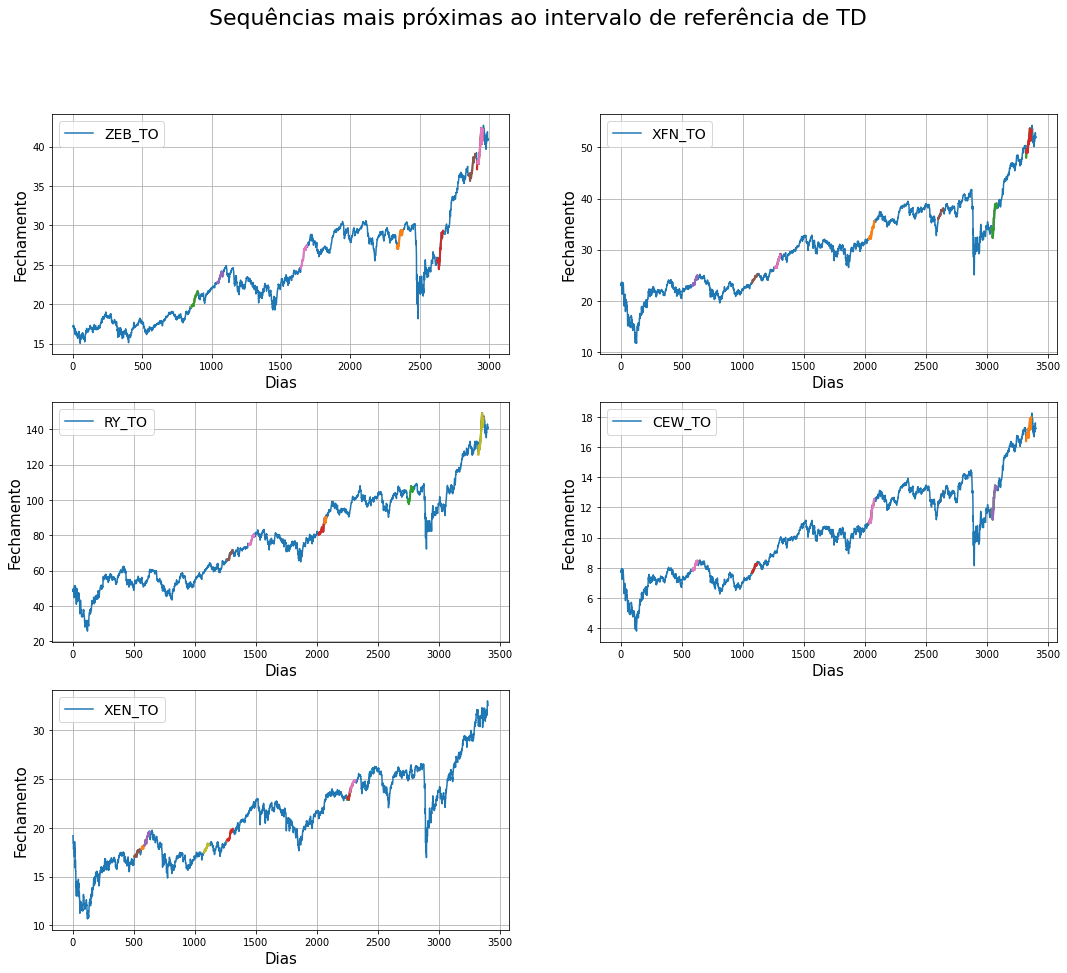

In [283]:
Figura, Eixo = plt.subplots( figsize=(18, 15) )

Coluna = 2
Linha = 3

Figura.suptitle('Sequências mais próximas ao intervalo de referência de TD', fontsize=22, color='black')

# ZEB_TO
plt.subplot( Linha, Coluna, 1 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.grid()
plt.plot(T_df1['Close'], label = 'ZEB_TO')
plt.legend(loc='upper left', fontsize = 14)

for idx in idxs1:
    plt.plot(range(idx, idx+len(Q_df['Close'])), T_df1['Close'].values[idx:idx+len(Q_df['Close'])], lw=2)

# XFN_TO
plt.subplot( Linha, Coluna, 2 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.grid()
plt.plot(T_df2['Close'], label = 'XFN_TO')
plt.legend(loc='upper left', fontsize = 14)

for idx in idxs2:
    plt.plot(range(idx, idx+len(Q_df['Close'])), T_df2['Close'].values[idx:idx+len(Q_df['Close'])], lw=2)

# RY_TO
plt.subplot( Linha, Coluna, 3 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.grid()
plt.plot(T_df3['Close'], label = 'RY_TO')
plt.legend(loc='upper left', fontsize = 14)

for idx in idxs3:
    plt.plot(range(idx, idx+len(Q_df['Close'])), T_df3['Close'].values[idx:idx+len(Q_df['Close'])], lw=2)

# CEW_TO
plt.subplot( Linha, Coluna, 4 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.grid()
plt.plot(T_df4['Close'], label = 'CEW_TO')
plt.legend(loc='upper left', fontsize = 14)

for idx in idxs4:
    plt.plot(range(idx, idx+len(Q_df['Close'])), T_df4['Close'].values[idx:idx+len(Q_df['Close'])], lw=2)

# XEN_TO
plt.subplot( Linha, Coluna, 5 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.grid()
plt.plot(T_df5['Close'], label = 'XEN_TO')
plt.legend(loc='upper left', fontsize = 14)

for idx in idxs5:
    plt.plot(range(idx, idx+len(Q_df['Close'])), T_df5['Close'].values[idx:idx+len(Q_df['Close'])], lw=2)

plt.show()

### Plot da menor distância para cada série

In [242]:
# índice da distância com o perfil mais próximo ao do padrão TD
idx1 = np.argmin(distance_profile_ZEB_TO)
idx2 = np.argmin(distance_profile_XFN_TO)
idx3 = np.argmin(distance_profile_RY_TO)
idx4 = np.argmin(distance_profile_CEW_TO)
idx5 = np.argmin(distance_profile_XEN_TO)

In [243]:
TDTO_pattern_norm = stumpy.core.z_norm(df_TD_TO_pattern['Close'].values)

ZEBTO_norm = stumpy.core.z_norm(ZEB_TO['Close'].values[idx1:idx1+len(df_TD_TO_pattern['Close'])])
XFNTO_norm = stumpy.core.z_norm(XFN_TO['Close'].values[idx2:idx2+len(df_TD_TO_pattern['Close'])])
RYTO_norm = stumpy.core.z_norm(RY_TO['Close'].values[idx3:idx3+len(df_TD_TO_pattern['Close'])])
CEWTO_norm = stumpy.core.z_norm(CEW_TO['Close'].values[idx4:idx4+len(df_TD_TO_pattern['Close'])])
XENTO_norm = stumpy.core.z_norm(XEN_TO['Close'].values[idx5:idx5+len(df_TD_TO_pattern['Close'])])

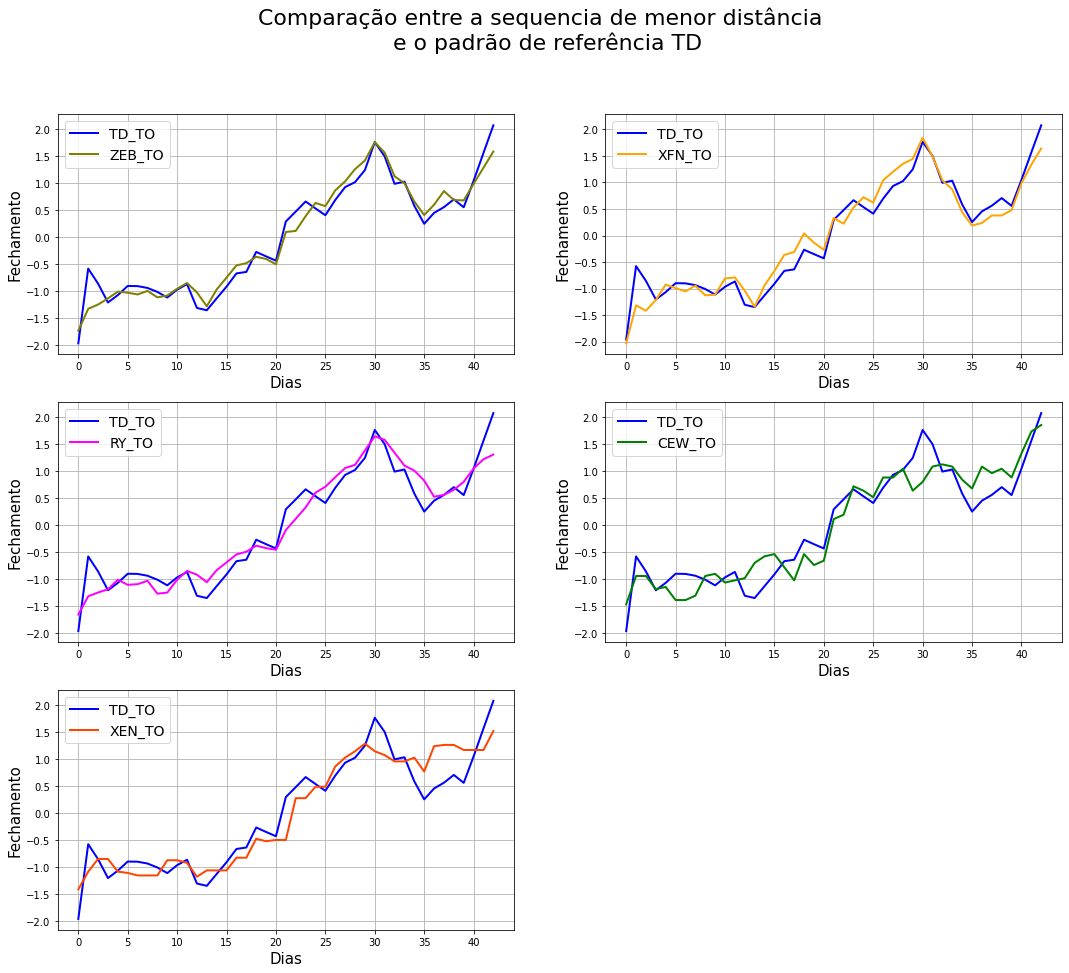

In [285]:
Figura, Eixo = plt.subplots( figsize=(18, 15) )

Coluna = 2
Linha = 3

plt.subplot( Linha, Coluna, 1 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.xticks(range(0,41,5))
plt.plot(TDTO_pattern_norm, lw=2, color="blue", label = 'TD_TO')
plt.plot(ZEBTO_norm, lw=2, color='olive', label = 'ZEB_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.subplot( Linha, Coluna, 2 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.xticks(range(0,41,5))
plt.yticks(np.arange(-2,2.5,0.5))
plt.plot(TDTO_pattern_norm, lw=2, color="blue", label = 'TD_TO')
plt.plot(XFNTO_norm, lw=2, color='orange', label = 'XFN_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.subplot( Linha, Coluna, 3 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.xticks(range(0,41,5))
plt.plot(TDTO_pattern_norm, lw=2, color="blue", label = 'TD_TO')
plt.plot(RYTO_norm, lw=2, color='fuchsia', label = 'RY_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.subplot( Linha, Coluna, 4 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.xticks(range(0,41,5))
plt.plot(TDTO_pattern_norm, lw=2, color="blue", label = 'TD_TO')
plt.plot(CEWTO_norm, lw=2, color='green', label = 'CEW_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

plt.subplot( Linha, Coluna, 5 )
plt.xlabel('Dias', fontsize ='15')
plt.ylabel('Fechamento', fontsize='15')
plt.xticks(range(0,41,5))
plt.plot(TDTO_pattern_norm, lw=2, color="blue", label = 'TD_TO')
plt.plot(XENTO_norm, lw=2, color='orangered', label = 'XEN_TO')
plt.legend(loc='upper left', fontsize = 14)
plt.grid()

Figura.suptitle('Comparação entre a sequencia de menor distância \n e o padrão de referência TD', fontsize=22, color='black')
plt.show()


# Análise dos resultados

Ficou claro que os ativos que apresentaram mais proximidade com a movimentação financeira da Toronto Dominion Bank também pertencem a bolsa de valores de Toronto, um ponto que favorece a correlação positiva entre eles. Além disso, devemos analisar se esses ativos estão em setores de mercado semelhantes. Vejamos:

* **ZEB - BMO Equal Weight Banks Index ETF**: Replica o desempenho do setor do índice Solactive Equal Weight Canada Banks, que inclui títulos listados na bolsa canadense no setor bancário diversificado. Dentro de suas top holdings estão a Royal Bank e a Toronto Dominion.
* **XFN - iShares S&P/TSX Capped Financials Index ETF**: Replica o desempenho do S&P/TSX Capped Financials Index, composto por títulos de emissores do setor financeiro canadense.  Dentro de suas top holdings estão a Royal Bank e a Toronto Dominion.
* **RY - Royal Bank of Canada**: empresa multinacional de serviços financeiros e o maior banco canadense sediado em Toronto e Montreal, Canadá.
* **CEW - iShares Equal Weight Banc & Lifeco ETF**: O fundo foi criado para fornecer aos investidores um investimento diversificado e ponderado em uma carteira de bancos canadenses e companhias de seguros de vida. A CEW investe, em bases igualmente ponderadas, em ações ordinárias dos maiores bancos canadenses e seguradoras de vida canadenses. Dentro de suas top holdings estão a Royal Bank e a Toronto Dominion.
* **XEN - iShares Jantzi Social Index Fund**: O ETF busca proporcionar crescimento de capital de longo prazo replicando o desempenho do Jantzi Social Index. Em condições normais de mercado, o ETF investirá principalmente em títulos de ações canadenses. O Índice é composto por títulos de emissores canadenses selecionados pela Jantzi com base em critérios para identificar empresas que refletem um padrão mais alto de desempenho ambiental e social. Dentro de suas top holdings estão a Royal Bank e a Toronto Dominion.

Todos esses ativos estão ligados ao setor financeiro e os ETFs possuem a Toronto Dominion Bank como um dos top 10 em seu portifólio. 

# Referências



*   Fast Pattern Searching with STUMPY: https://towardsdatascience.com/the-matrix-profile-e4a679269692
*   The Matrix Profile: https://towardsdatascience.com/part-7-fast-pattern-searching-with-stumpy-2baf610a8de1
*   https://www.blackrock.com/ca/investors/en/literature/etf-summary/xen-facts-en-ca.pdf
*   https://www.blackrock.com/ca/investors/en/literature/etf-summary/cew-facts-en-ca.pdf
*   https://www.etfsage.ca/etfs/XFN.php
*   https://www.bmogam.com/ca-en/advisors/zeb-bmo-equal-weight-banks-index-etf/
*   https://corporatefinanceinstitute.com/resources/careers/companies/top-banks-in-canada/



In [ ]:
!sudo apt update
!pip install nbconvert
!sudo apt-get install pandoc
!sudo apt-get install texlive-full texlive-xetex texlive-fonts-recommended texlive-generic-recommended texlive-latex-extra

In [ ]:
!jupyter nbconvert --to pdf Desafio_final_i2a2.ipynb